In [44]:
import numpy as np
from pymanopt.manifolds import Sphere
import matplotlib.pyplot as plt
import mala.potentials
import mala.metropolis_hastings as mh
import mala.icosehedron as ico
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

%matplotlib notebook

%load_ext autoreload
%autoreload 2

phi = (1 + 5 ** 0.5) / 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A crash-course on how the icosahedron is currently implemented

Note: with the exception of the first figure, you should be able to rotate all of the figures in this notebook. If for some reason you can't, try re-running the first block, I have no idea why it doesn't take the first time sometimes.

Pre-emptively run tests to make sure all's working correctly:

In [75]:
from test_icosehedron import test_chart_maps, test_chart_transitions

# tests generation of icosahedron face graph, transformations into/out
# of chart image
test_chart_maps()
# tests mapping points between charts
#test_chart_transitions()

# Generate vertices via G 

We have two generators, a permutation $(x,y,z)\rightarrow(z,x,y)$ and a negation $(x,y,z)\rightarrow(-x,y,z)$

$$G_1 = \begin{bmatrix}
0 & 0 & 1\\
1 & 0 & 0\\
0 & 1 & 0
\end{bmatrix},\qquad
G_2 = \begin{bmatrix}
-1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}$$

We can pick any arbitrary vertex of the icosehedron (e.g. $v_0 = (1,\phi,0)$) and its orbit under G will generate all the icosehedron vertices. We name the vertices by the group elements that generated them (this naming isn't unique: two elements of the group generate any $v_1$ from $v_0$, but we'll just stick to one of the two WOLG).

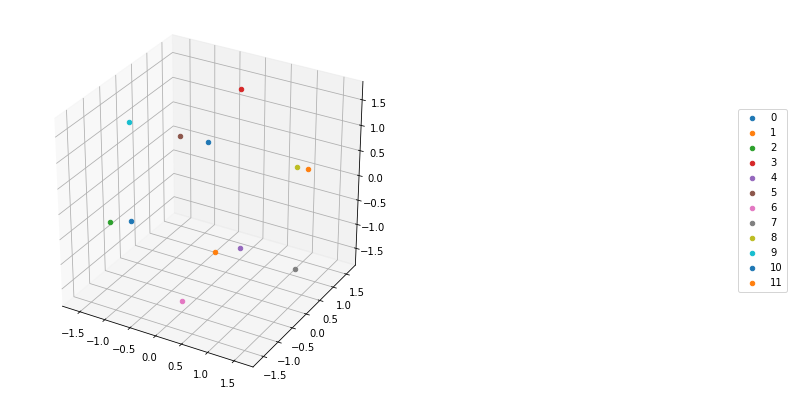

In [49]:
# To view the legend with the vertices' names, uncomment this line -------------------
%matplotlib inline
# To view the legend with the vertices' names, uncomment this line -------------------
# Note that you'll have to re-run the first section (%matplotlib notebook) to revert
# back to rotating figures

G = ico.generate_G(verbose=False)
V = ico.generate_V(G)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for idx,v in enumerate(V):
    ax.scatter(v.p[0],v.p[1],v.p[2],label=idx)
    
plt.legend(loc='right', bbox_to_anchor=(1, 0., 1, 1))
plt.show()

# Building face graph

Takes in a list of named vertices, assumed to correspond to the icosehedron. First builds a graph of labeled vertices, and then the dual graph, where each node corresponds to a face whose name is a tuple of vertex names

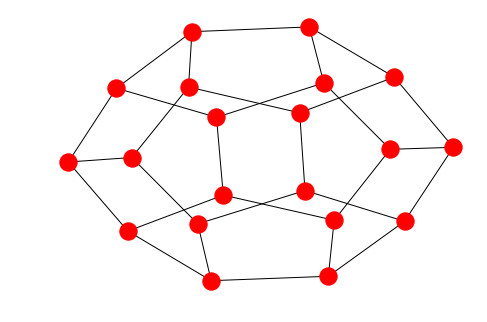

In [70]:
face_graph,vertex_graph = ico.build_face_graph(V,verify=True)
nx.draw(face_graph)

# face dict maps nodes in our face graph to ambient_face objects,
# which contain geometric information about the face
face_dict = ico.build_face_map(face_graph,V)

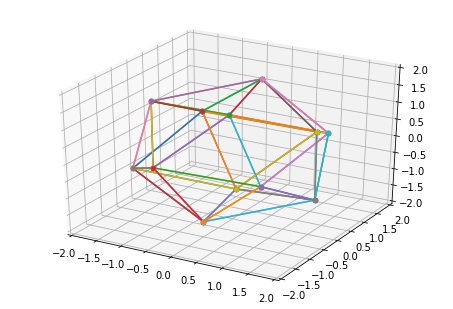

In [72]:
# Draw this monstrosity to make sure its doing what we want
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
for face_node in list(face_graph.nodes()):
    u,v,w = face_dict[face_node].return_coors()
    for x,y in [[u,v],[v,w],[u,w]]:
        ax.plot([x[0],y[0]],[x[1],y[1]],[x[2],y[2]])
    for v in face_dict[face_node].return_coors():
        ax.scatter(v[0],v[1],v[2])
    
ax.axes.set_xlim3d(left=-2, right=2) 
ax.axes.set_ylim3d(bottom=-2, top=2) 
ax.axes.set_zlim3d(bottom=-2, top=2) 
plt.show()

#look, a pretty icosehedron

# Transforming between chart coordinates and Euclidean coordinates

We need methods for projecting points on the sphere down into the $\mathbb{R}^2$ plane of the face and vice versa.

Our faces have a "handedness" defined by cross-prod of first and 2nd axis. When we build our face map, we make sure that we define v_1, v_2, and v_3 so that our choice of spanning vectors have a cross-product that points outwards wrt the sphere. We call this being "left-handed." (Originally this was being "right-handed" but I realized I'd flipped something so I went through and changed our convention but haven't yet re-named everything. Just know that all our faces are "left-handed".


Nonetheless: in general we can't be guaranteed a surface is orientable. If a face were to be left-handed, we could handle it. In this case, we'd flip orientation to align first axis with positive x-axis. We only take the x- and y-coordinates as the image of our chart, so being flipped to top vs bottom of sphere doesn't matter.


Is our target right-handed?  True


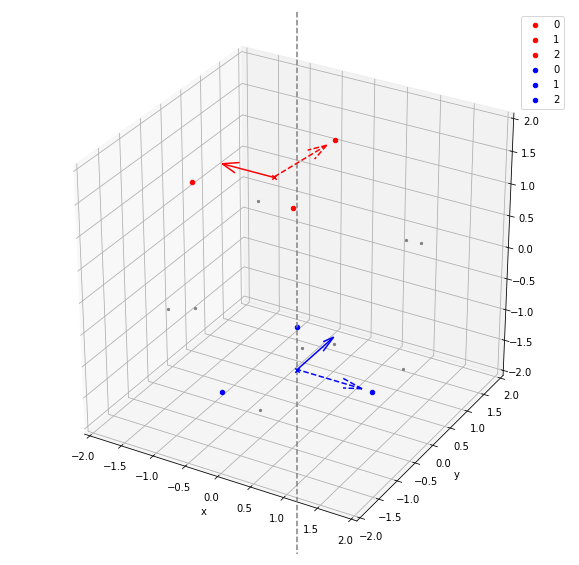

In [84]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for idx,v in enumerate(V):
    ax.scatter(v.p[0],v.p[1],v.p[2],marker='.',color='grey')

# some options for examining transformation of different faces

#target_face = ico.ambient_face(V[6],V[7],V[1])
target_face = ico.ambient_face(V[0],V[9],V[3])
#target_face = ico.ambient_face(V[6],V[2],V[10])
#target_face = face_dict[('G_2*v_0', 'G_1^1@Identity*v_0', 'G_1^2@G_1@G_2@G_1@G_2@G_1*v_0')]

print('Is our target right-handed? ',ico.righthand_face(target_face))

# get the map that rotates our face centroid to z-axis and aligns face spanning vectors
# with x and y axis

# chart transformation
R = ico.chart_transformation(target_face)
R_v_1,R_v_2,R_v_3 = [ico.vertex(np.matmul(R,v),'dummy') for v in target_face.return_coors()]
transformed_face = ico.ambient_face(R_v_1,R_v_2,R_v_3)

color_list = ['r','blue']
for f_idx,face in enumerate([target_face,transformed_face]):
    for v_idx,p in enumerate(face.return_coors()):
        ax.scatter(p[0],p[1],p[2],
                   color=color_list[f_idx],
                   label=str(v_idx))
        
    centroid = face.ctd_coors
    ax.scatter(centroid[0],centroid[1],centroid[2],marker='x',color=color_list[f_idx])
    style_list = ['-','--']
    for basis_idx,v_prime in enumerate([face.basis_1,face.basis_2]):
        ax.quiver(centroid[0],centroid[1],centroid[2],
             v_prime[0],v_prime[1],v_prime[2],linestyle=style_list[basis_idx],color = color_list[f_idx])

# draw z-axis
ax.plot([0,0],[0,0],[-5,5],'--',color='grey')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.axes.set_xlim3d(left=-2, right=2) 
ax.axes.set_ylim3d(bottom=-2, top=2) 
ax.axes.set_zlim3d(bottom=-2, top=2) 

plt.legend()
plt.show()

## Right now, our charts have a radius 2x that of the faces' median

We want to be able to check whether the projection of a particular point (a) lies within the image of the chart of a face and/or (b) lies within the face $\textit{itself}$.

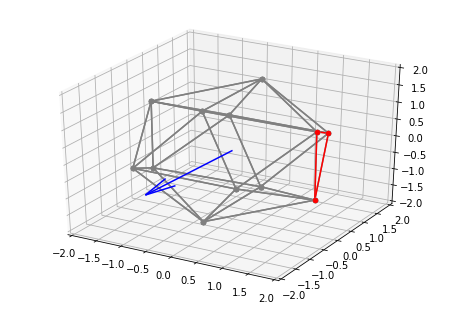

Face centered at  [-0.   -0.    1.51]
   v1 =  dummy  at  [-0.58 -1.    1.51]
   v2 =  dummy  at  [-0.58  1.    1.51]
   v3 =  dummy  at  [ 1.15 -0.    1.51]
   spanning vector 1= [-1.11022302e-16  1.00000000e+00  0.00000000e+00]
   spanning vector 2= [1.00000000e+00 8.35335786e-17 0.00000000e+00]


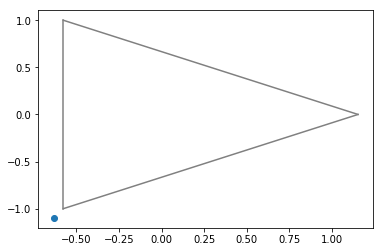

Is  [-1.09818547 -1.09818547 -1.09818547]  in this chart?  False
Is  [-1.09818547 -1.09818547 -1.09818547]  in this face?  False


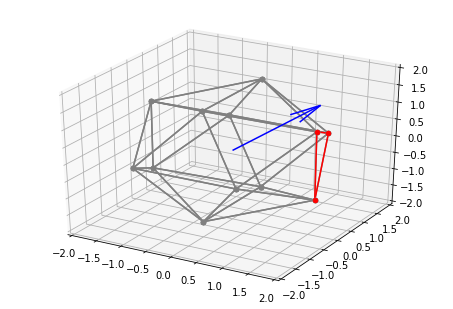

Face centered at  [-0.   -0.    1.51]
   v1 =  dummy  at  [-0.58 -1.    1.51]
   v2 =  dummy  at  [-0.58  1.    1.51]
   v3 =  dummy  at  [ 1.15 -0.    1.51]
   spanning vector 1= [-1.11022302e-16  1.00000000e+00  0.00000000e+00]
   spanning vector 2= [1.00000000e+00 8.35335786e-17 0.00000000e+00]


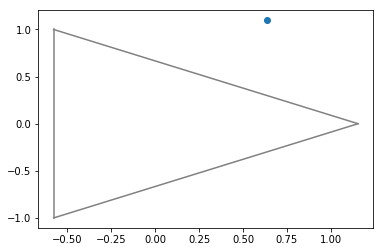

Is  [1.09818547 1.09818547 1.09818547]  in this chart?  True
[0.63403768 1.09818547]
Is  [1.09818547 1.09818547 1.09818547]  in this face?  False


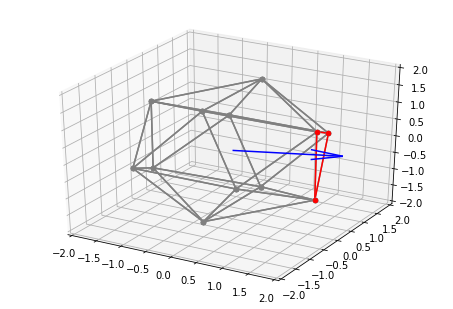

Face centered at  [-0.   -0.    1.51]
   v1 =  dummy  at  [-0.58 -1.    1.51]
   v2 =  dummy  at  [-0.58  1.    1.51]
   v3 =  dummy  at  [ 1.15 -0.    1.51]
   spanning vector 1= [-1.11022302e-16  1.00000000e+00  0.00000000e+00]
   spanning vector 2= [1.00000000e+00 8.35335786e-17 0.00000000e+00]


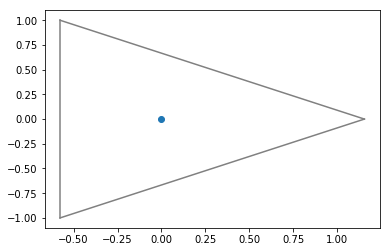

Is  [1.77690142 0.67871595 0.        ]  in this chart?  True
[ 0.00000000e+00 -1.16470832e-16]
Is  [1.77690142 0.67871595 0.        ]  in this face?  True


In [77]:
target_idx = 19
target_face = face_dict[list(face_graph.nodes())[target_idx]]
point = -2*np.array([1,1,1])

sphere_radius = np.linalg.norm(target_face.v_1.p,ord=2)

for point in [-2*np.array([1,1,1]),np.array([1,1,1]),2*target_face.ctd_coors]:
    point = sphere_radius*np.divide(point,np.linalg.norm(point,ord=2))

    fig = plt.figure()
    ax = Axes3D(fig)
    for idx,face_node in enumerate(list(face_graph.nodes())):
        if idx==target_idx:
            plot_color = 'red'
        else:
            plot_color='grey'

        u,v,w = face_dict[face_node].return_coors()
        for x,y in [[u,v],[v,w],[u,w]]:
            ax.plot([x[0],y[0]],[x[1],y[1]],[x[2],y[2]],color=plot_color)
        for v in face_dict[face_node].return_coors():
            ax.scatter(v[0],v[1],v[2],color=plot_color)

    ax.quiver(0,0,0,point[0],point[1],point[2],color='b')

    ax.axes.set_xlim3d(left=-2, right=2) 
    ax.axes.set_ylim3d(bottom=-2, top=2) 
    ax.axes.set_zlim3d(bottom=-2, top=2) 
    plt.show()
    
    # plot in chart image
    fig = plt.figure()
    
    chart_image_face = target_face.transform_face_by_chart()
    chart_image_face.print()
    u,v,w = chart_image_face.return_coors()
    for x,y in [[u,v],[v,w],[u,w]]:
        plt.plot([x[0],y[0]],[x[1],y[1]],color='grey')
        
    chart_image_pt = ico.euclidean2chart(point,target_face)
    plt.plot([chart_image_pt[0]],[chart_image_pt[1]],'o')
    
    plt.show()
    
    

    print('Is ',point,' in this chart? ',ico.check_if_point_in_chart(point,target_face))
    print('Is ',point,' in this face? ',np.all(ico.check_if_point_in_face(point,target_face)))

## If we've stepped over the edge of a face, we want to know which face we've stepped into

In [23]:
edge = list(face_graph.edges())[0]
origin_face = face_dict[edge[0]]
dest_face = face_dict[edge[1]]

MISMATCH DETECTED
     true edge  ['G_1^1@Identity*v_0', 'G_1^2@G_1@G_2@G_1@G_2@G_1*v_0']
     detected edge  ['G_2*v_0', 'G_1^1@Identity*v_0']
Crossed  1  boundaries
Face centered at  [0.   0.   1.51]
   v1 =  G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^1@Identity*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1@G_2@G_1@G_2@G_1*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [0. 1. 0.]
   spanning vector 2= [1. 0. 0.]
crossed line  l3


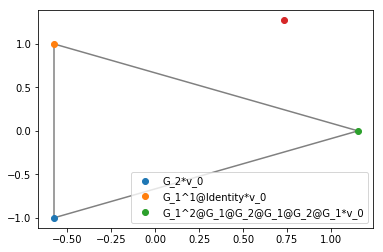

MISMATCH DETECTED
     true edge  ['G_2*v_0', 'v_0']
     detected edge  ['G_1^1@Identity*v_0', 'G_2*v_0']
Crossed  1  boundaries
Face centered at  [0.   0.   1.51]
   v1 =  G_1^1@Identity*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  v_0  at  [1.15 0.   1.51]
   spanning vector 1= [ 1.11022302e-16  1.00000000e+00 -1.11022302e-16]
   spanning vector 2= [ 1.00000000e+00 -1.28197512e-16  0.00000000e+00]
crossed line  l3


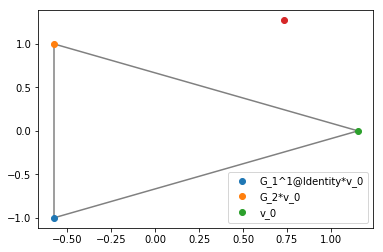

MISMATCH DETECTED
     true edge  ['G_2*v_0', 'G_1^1@G_1@G_2@G_1@G_2@G_1*v_0']
     detected edge  ['G_2*v_0', 'G_1^2@G_1@G_2@G_1@G_1@G_2*v_0']
Crossed  1  boundaries
Face centered at  [ 0.   -0.    1.51]
   v1 =  G_1^1@G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1@G_2@G_1@G_1@G_2*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [-1.11022302e-16  1.00000000e+00  0.00000000e+00]
   spanning vector 2= [1.00000000e+00 3.20493781e-17 0.00000000e+00]
crossed line  l1


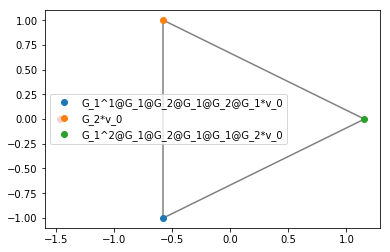

MISMATCH DETECTED
     true edge  ['G_1^2@G_1@G_2@G_1@G_1@G_2*v_0', 'G_2*v_0']
     detected edge  ['G_1^1@G_1@G_2@G_1@G_2@G_1*v_0', 'G_2*v_0']
Crossed  1  boundaries
Face centered at  [ 0.   -0.    1.51]
   v1 =  G_1^1@G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1@G_2@G_1@G_1@G_2*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [-1.11022302e-16  1.00000000e+00  0.00000000e+00]
   spanning vector 2= [1.00000000e+00 3.20493781e-17 0.00000000e+00]
crossed line  l3


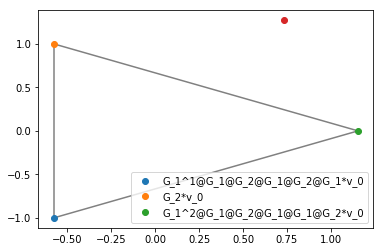

MISMATCH DETECTED
     true edge  ['v_0', 'G_1^1@G_1@G_2@G_1@G_2@G_1*v_0']
     detected edge  ['G_2*v_0', 'G_1^1@G_1@G_2@G_1@G_2@G_1*v_0']
Crossed  1  boundaries
Face centered at  [-0.   -0.    1.51]
   v1 =  G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^1@G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58  1.    1.51]
   v3 =  v_0  at  [ 1.15 -0.    1.51]
   spanning vector 1= [3.33066907e-16 1.00000000e+00 0.00000000e+00]
   spanning vector 2= [ 1.00000000e+00 -3.20493781e-16  0.00000000e+00]
crossed line  l3


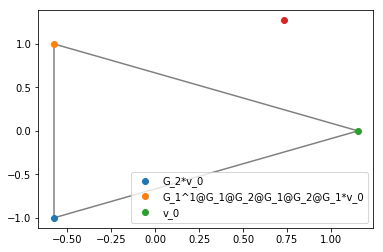

MISMATCH DETECTED
     true edge  ['G_1^2@G_1@G_2@G_1@G_1@G_2*v_0', 'G_1^2@G_1@G_2@G_1@G_2@G_1*v_0']
     detected edge  ['G_2*v_0', 'G_1^2@G_1@G_2@G_1@G_2@G_1*v_0']
Crossed  1  boundaries
Face centered at  [0.   0.   1.51]
   v1 =  G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^2@G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1@G_2@G_1@G_1@G_2*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [-5.55111512e-17  1.00000000e+00 -1.11022302e-16]
   spanning vector 2= [ 1.00000000e+00  0.00000000e+00 -1.28197512e-16]
crossed line  l3


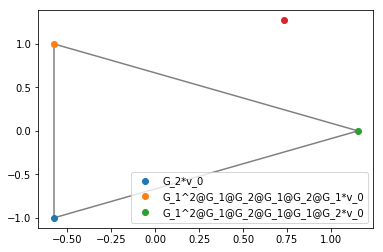

MISMATCH DETECTED
     true edge  ['G_1@G_2@G_1@G_1@G_2*v_0', 'G_1@G_2@G_1@G_2@G_1*v_0']
     detected edge  ['G_1@G_2@G_1@G_1@G_2*v_0', 'G_1^1@G_1^2@G_2@G_1@G_2*v_0']
Crossed  1  boundaries
Face centered at  [-0.    0.    1.51]
   v1 =  G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1@G_2@G_1@G_1@G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^1@G_1^2@G_2@G_1@G_2*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [-1.11022302e-16  1.00000000e+00  0.00000000e+00]
   spanning vector 2= [1.00000000e+00 1.16995628e-16 1.28197512e-16]
crossed line  l1


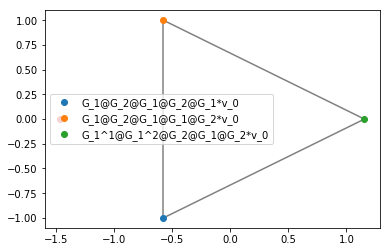

MISMATCH DETECTED
     true edge  ['G_1@G_2@G_1@G_1@G_2*v_0', 'G_1^1@G_1^2@G_2@G_1@G_2*v_0']
     detected edge  ['G_1@G_2@G_1@G_2@G_1*v_0', 'G_1@G_2@G_1@G_1@G_2*v_0']
Crossed  1  boundaries
Face centered at  [-0.    0.    1.51]
   v1 =  G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1@G_2@G_1@G_1@G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^1@G_1^2@G_2@G_1@G_2*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [-1.11022302e-16  1.00000000e+00  0.00000000e+00]
   spanning vector 2= [1.00000000e+00 1.16995628e-16 1.28197512e-16]
crossed line  l3


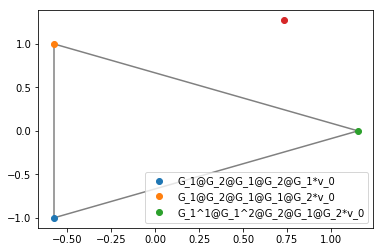

MISMATCH DETECTED
     true edge  ['G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0', 'G_1@G_2@G_1@G_2@G_1*v_0']
     detected edge  ['G_1@G_2@G_1@G_1@G_2*v_0', 'G_1@G_2@G_1@G_2@G_1*v_0']
Crossed  1  boundaries
Face centered at  [-0.   -0.    1.51]
   v1 =  G_1@G_2@G_1@G_1@G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0  at  [ 1.15 -0.    1.51]
   spanning vector 1= [0. 1. 0.]
   spanning vector 2= [ 1.00000000e+00 -1.78691642e-17  0.00000000e+00]
crossed line  l3


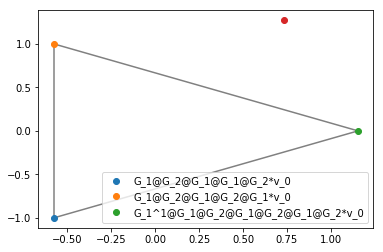

MISMATCH DETECTED
     true edge  ['G_1^1@G_1^2@G_2@G_1@G_2*v_0', 'G_1^2@G_1^2@G_2@G_1*v_0']
     detected edge  ['G_1@G_2@G_1@G_2@G_1*v_0', 'G_1^1@G_1^2@G_2@G_1@G_2*v_0']
Crossed  1  boundaries
Face centered at  [-0.    0.    1.51]
   v1 =  G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^1@G_1^2@G_2@G_1@G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1^2@G_2@G_1*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [1.11022302e-16 1.00000000e+00 0.00000000e+00]
   spanning vector 2= [ 1.00000000e+00 -3.20493781e-17  0.00000000e+00]
crossed line  l3


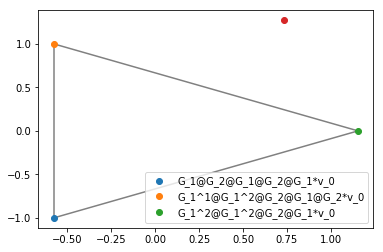

MISMATCH DETECTED
     true edge  ['G_1@G_2@G_1@G_2@G_1*v_0', 'G_1^2@G_2*v_0']
     detected edge  ['G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0', 'G_1@G_2@G_1@G_2@G_1*v_0']
Crossed  1  boundaries
Face centered at  [-0.   -0.    1.51]
   v1 =  G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_2*v_0  at  [ 1.15 -0.    1.51]
   spanning vector 1= [5.55111512e-17 1.00000000e+00 0.00000000e+00]
   spanning vector 2= [ 1.00000000e+00 -6.40987562e-17  0.00000000e+00]
crossed line  l3


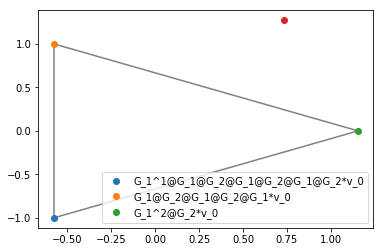

MISMATCH DETECTED
     true edge  ['G_1@G_2@G_1@G_1@G_2*v_0', 'G_1^2@G_1@G_2@G_1@G_2@G_1*v_0']
     detected edge  ['G_1^1@G_1^2@G_2@G_1@G_2*v_0', 'G_1@G_2@G_1@G_1@G_2*v_0']
Crossed  1  boundaries
Face centered at  [0.   0.   1.51]
   v1 =  G_1^1@G_1^2@G_2@G_1@G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1@G_2@G_1@G_1@G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1@G_2@G_1@G_2@G_1*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [0. 1. 0.]
   spanning vector 2= [1. 0. 0.]
crossed line  l3


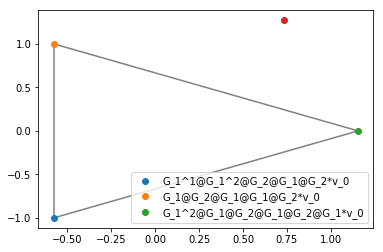

MISMATCH DETECTED
     true edge  ['G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0', 'G_1^2@G_1@G_2@G_1@G_1@G_2*v_0']
     detected edge  ['G_1@G_2@G_1@G_1@G_2*v_0', 'G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0']
Crossed  1  boundaries
Face centered at  [0.   0.   1.51]
   v1 =  G_1@G_2@G_1@G_1@G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1@G_2@G_1@G_1@G_2*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [1.11022302e-16 1.00000000e+00 0.00000000e+00]
   spanning vector 2= [ 1.00000000e+00 -3.20493781e-17  0.00000000e+00]
crossed line  l3


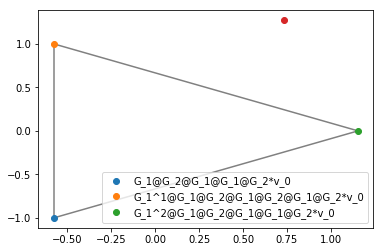

MISMATCH DETECTED
     true edge  ['G_1^1@G_1^2@G_2@G_1@G_2*v_0', 'G_1^1@Identity*v_0']
     detected edge  ['G_1^1@Identity*v_0', 'G_1^2@G_1^2@G_2@G_1*v_0']
Crossed  1  boundaries
Face centered at  [-0.    0.    1.51]
   v1 =  G_1^1@G_1^2@G_2@G_1@G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^1@Identity*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1^2@G_2@G_1*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [0. 1. 0.]
   spanning vector 2= [1. 0. 0.]
crossed line  l1


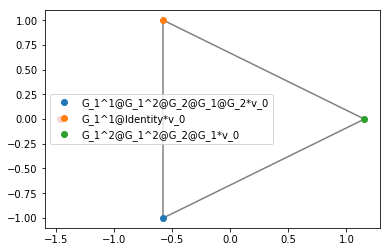

MISMATCH DETECTED
     true edge  ['G_1^1@Identity*v_0', 'G_1^2@G_1^2@G_2@G_1*v_0']
     detected edge  ['G_1^1@G_1^2@G_2@G_1@G_2*v_0', 'G_1^1@Identity*v_0']
Crossed  1  boundaries
Face centered at  [-0.    0.    1.51]
   v1 =  G_1^1@G_1^2@G_2@G_1@G_2*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^1@Identity*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_1^2@G_2@G_1*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [0. 1. 0.]
   spanning vector 2= [1. 0. 0.]
crossed line  l3


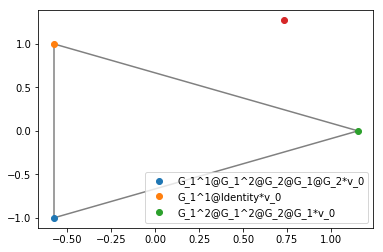

MISMATCH DETECTED
     true edge  ['G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0', 'G_1^1@G_1@G_2@G_1@G_2@G_1*v_0']
     detected edge  ['G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0', 'G_1^2@G_2*v_0']
Crossed  1  boundaries
Face centered at  [-0.    0.    1.51]
   v1 =  G_1^1@G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^1@G_1@G_2@G_1@G_2@G_1@G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  G_1^2@G_2*v_0  at  [1.15 0.   1.51]
   spanning vector 1= [-1.11022302e-16  1.00000000e+00  0.00000000e+00]
   spanning vector 2= [1.00000000e+00 1.13692498e-16 1.28197512e-16]
crossed line  l1


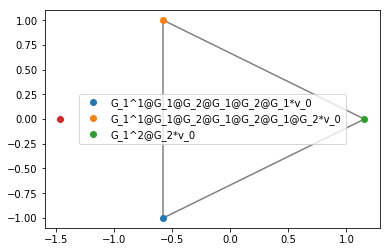

MISMATCH DETECTED
     true edge  ['G_1^2@G_2*v_0', 'v_0']
     detected edge  ['G_1^1@G_1@G_2@G_1@G_2@G_1*v_0', 'G_1^2@G_2*v_0']
Crossed  1  boundaries
Face centered at  [ 0.   -0.    1.51]
   v1 =  G_1^1@G_1@G_2@G_1@G_2@G_1*v_0  at  [-0.58 -1.    1.51]
   v2 =  G_1^2@G_2*v_0  at  [-0.58  1.    1.51]
   v3 =  v_0  at  [ 1.15 -0.    1.51]
   spanning vector 1= [2.22044605e-16 1.00000000e+00 0.00000000e+00]
   spanning vector 2= [ 1.00000000e+00 -1.60246891e-16  0.00000000e+00]
crossed line  l3


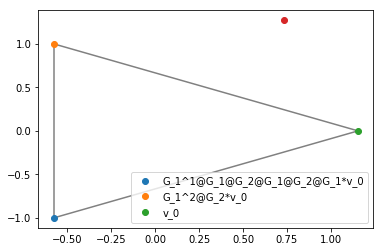

In [106]:
test_chart_transitions()